<a href="https://colab.research.google.com/github/rachioko/Neural-Networks-with-Tensorflow/blob/master/artistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook shows a project which will attempt to predict the artist who painted an image of an artwork. We will be using a convolution neural network architechture in tensorflow.

In [0]:
import pandas as pd
import numpy as np
import os
#from tqdm import tqdm 
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv("all_data_info.csv")
traininfo = pd.read_csv("train_info.csv")

In [0]:
print (df.head(5))
print (df.describe())
print(df['artist'].value_counts())

#create artist dictionary
artists = {} 
for a in df['artist']:
  if (a not in artists):
    artists[a] = 1
  else:
    artists[a] += 1
 

print("\nHow many artists? \n")
print(len(artists))

           artist    date     genre  ...  artist_group  in_train  new_filename
0  Barnett Newman  1955.0  abstract  ...    train_only      True    102257.jpg
1  Barnett Newman  1950.0  abstract  ...    train_only      True     75232.jpg
2     kiri nichol  2013.0       NaN  ...     test_only     False     32145.jpg
3     kiri nichol  2013.0       NaN  ...     test_only     False     20304.jpg
4     kiri nichol  2013.0       NaN  ...     test_only     False       836.jpg

[5 rows x 12 columns]
             pixelsx        pixelsy    size_bytes
count  103250.000000  103250.000000  1.032500e+05
mean      960.808097     984.089976  3.883235e+05
std       596.270314     625.139336  8.784776e+05
min       200.000000     162.000000  3.516000e+03
25%       581.000000     599.000000  9.438625e+04
50%       800.000000     800.000000  1.676700e+05
75%      1102.000000    1097.000000  3.401280e+05
max     25528.000000    9541.000000  3.244314e+07
Zdislav Beksinski                                    

So we have 2319 artists to look at, but for this project we will only choose 4 for labels to use for the Image classification.

In [0]:
#get 4 artists with 500 entries for new dataframe
p_artists = ['Ivan Shishkin', 'Pablo Picasso', 'Marc Chagall', 'Rembrandt' ]
art_df = df[df.artist.isin(p_artists)]
art_df_train = traininfo[traininfo.filename.isin(art_df.new_filename)]
art_df_test = art_df[~art_df.new_filename.isin(art_df_train.filename)]

In [0]:
training_dir = "/content/drive/My Drive/Colab Notebooks/Data/art_training/"
test_dir = "/content/drive/My Drive/Colab Notebooks/Data/art_test/"

In [0]:
#list of training and test : images and labels
train_img = os.listdir(training_dir)
train_labels = pd.Series.tolist(art_df['artist'][art_df['new_filename'].isin(train_img)])
test_img = os.listdir(test_dir)
test_labels = pd.Series.tolist(art_df['artist'][art_df['new_filename'].isin(test_img)])

Lets get an example of a test image:

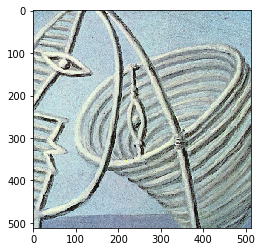

In [0]:
I = get_Image(test_img[89],test_dir)
plt.imshow(I)

In [0]:
#CNN Tensorflow  
#Training parameters
learning_rate = 0.01
num_steps = 300
batch_size =  45  


#Network Parameters   
num_input = 262144 #512*512 input
num_classes = 4
channels = 3
img_size = 512
dropout = 0.75 


In [0]:
#one_hot encode labels
def one_hot(X):
    X = np.asarray(X) 
    s = X.shape[0]
    X = X.reshape(s,1)
    labelencoder_X = LabelEncoder()
    X[:, 0] = labelencoder_X.fit_transform(X[:, 0])
    onehotencoder = OneHotEncoder(categories = 'auto')
    X = onehotencoder.fit_transform(X).toarray()

    return X

In [0]:
#get and process images (center crop) to 512X512 size
def get_Image(x, path):
# return image
    img = Image.open(path + x).convert("RGB")
    w, h = img.size
        
    left = (w - img_size)/2
    top = (h - img_size)/2
    right = (w + img_size)/2
    bottom = (h + img_size)/2
        
    img = img.crop((left,top, right, bottom))

    return img


In [0]:
#randomize training batch
def random_batch(batchsize, path):
    if path == training_dir:
        x = train_img
        y = train_labels
    elif path == test_dir:
        x = test_img 
        y = test_labels
   # Create a random index.
    idx = np.random.choice(len(x),size=batchsize, replace=False)
    
    # Use the random index to select random images and labels
    batch_x=[]
    batch_y=[]
    
    for i in idx:
        dex = x[i-1]
        img = get_Image(dex, path)
        img = np.asarray(img, dtype = np.float32)
        #img = np.float32(img)
        batch_x.append(img)
        label = y[i-1]
        batch_y.append(label)
    
    batch_x = np.asarray(batch_x)
    batch_y = one_hot(batch_y)
    batch_y = np.squeeze(batch_y)  
    
    return batch_x, batch_y,


In [0]:
with tf.name_scope('Placeholders'):
    X = tf.placeholder(tf.float32, [None, img_size, img_size, channels], name='art_images')
    Y = tf.placeholder(tf.float32, [None, num_classes], name='label')
    # dropout (keep probability)
    keep_prob = tf.placeholder(tf.float32, name='dropout') 

# Set model weights
with tf.name_scope('Weights'):
    weights = {
        # 3x3 conv, 3 input, 64outputs
        'wc1': tf.Variable(tf.random_normal([3, 3, 3, 64])),
        # 3x3 conv, 32 inputs, 64 outputs
        'wc2': tf.Variable(tf.random_normal([3, 3, 64, 128])),
        # 3x3 conv, 64 inputs, 128 outputs
        'wc3': tf.Variable(tf.random_normal([3, 3, 128, 256])),
        # 3x3 conv, 64 inputs, 128 outputs
        'wc4': tf.Variable(tf.random_normal([3, 3, 256, 128])),
        # 3x3 conv, 64 inputs, 128 outputs
        'wc5': tf.Variable(tf.random_normal([3, 3, 128, 64])),
        # 3x3 conv, 64 inputs, 128 outputs
        'wc6': tf.Variable(tf.random_normal([3, 3, 64, 32])),
         # fully connected, 7*7*64 inputs, 1024 outputs
        'wd1': tf.Variable(tf.random_normal([8*8*32, 2084])),
        # 1024 inputs, 10 outputs (class prediction)
        'out': tf.Variable(tf.random_normal([2084, num_classes]))
    }
    
    biases = {
        'bc1': tf.Variable(tf.random_normal([64])),
        'bc2': tf.Variable(tf.random_normal([128])),
        'bc3': tf.Variable(tf.random_normal([256])),
        'bc4': tf.Variable(tf.random_normal([128])),
        'bc5': tf.Variable(tf.random_normal([64])),
        'bc6': tf.Variable(tf.random_normal([32])),
        'bd1': tf.Variable(tf.random_normal([2084])),
        'out': tf.Variable(tf.random_normal([num_classes]))
    }
    

In [0]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

def conv_net(x, weights, biases, dropout):
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    
    #x = tf.reshape(x, shape=[-1,img_size, img_size, channels])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling)
    conv3 = maxpool2d(conv3, k=2)
    
     # Convolution Layer
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    # Max Pooling (down-sampling)
    conv4 = maxpool2d(conv4, k=2)

 # Convolution Layer
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)

 # Convolution Layer
    conv6 = conv2d(conv5, weights['wc6'], biases['bc6'])
    # Max Pooling (down-sampling)
    conv6 = maxpool2d(conv6, k=2)

    
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv6, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [0]:
with tf.name_scope('Model'):
    logits = tf.squeeze(conv_net(X, weights, biases, dropout))
    
    y_pred = tf.argmax(tf.nn.softmax(logits),axis=1)


with tf.name_scope('Loss'):
   
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
    

with tf.name_scope('Train_ops'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
with tf.name_scope('Metrics'):
    Y_true = tf.argmax(Y, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, Y_true),dtype=tf.float32))
    
    #Other operations
with tf.name_scope('summaries'):
    tf.summary.scalar('loss', loss)
    merged=tf.summary.merge_all()
    
with tf.name_scope('Misc'):
    init = tf.global_variables_initializer()
    
#Create a log file
train_writer = tf.summary.FileWriter('./graphs', tf.get_default_graph())

   

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
## Start training
with tf.Session() as sess:

   # Run the initializer
    sess.run(init)
    print("Optimization Started!")
#    # Fit all training data
    for step in range(1, num_steps+1):
        batch_x, batch_y = random_batch(batch_size, training_dir)
        feed_dictionary={X: batch_x, Y: batch_y, keep_prob: dropout}
        # Run optimization op (backprop)     
        sess.run([train_op], feed_dict=feed_dictionary)
#        _, summary, t_loss = sess.run([train_op,merged,loss], feed_dict=feed_dictionary)
#        train_writer.add_summary(summary, step)

        summary, acc = sess.run([merged,accuracy], feed_dict=feed_dictionary)
        train_writer.add_summary(summary, step)
        
        if step % 10 == 0:
            print ('Training acc:', acc)
          
             
    print("Optimization Finished!")
    
     #test
    batch_x, batch_y = random_batch(batch_size, test_dir)
    print('Test accuracy = ', 
          sess.run(accuracy, feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0}))


sess.close()
train_writer.close()
    

Optimization Started!
Training acc: 0.2888889
summary:  b'\n\x15\n\x0esummaries/loss\x15\x97\xd3\x8dR'

Training acc: 0.24444444
summary:  b'\n\x15\n\x0esummaries/loss\x15\xc6\xc7\x0bR'

Training acc: 0.31111112
summary:  b'\n\x15\n\x0esummaries/loss\x150\x91$Q'

Training acc: 0.31111112
summary:  b'\n\x15\n\x0esummaries/loss\x15\x92FOP'

Training acc: 0.22222222
summary:  b'\n\x15\n\x0esummaries/loss\x15\xab\x82{O'

Training acc: 0.2
summary:  b'\n\x15\n\x0esummaries/loss\x15\x89?\xb8O'

Training acc: 0.2888889
summary:  b'\n\x15\n\x0esummaries/loss\x15?\x00\xc5N'

Training acc: 0.17777778
summary:  b'\n\x15\n\x0esummaries/loss\x15\x15?\x9fN'

Training acc: 0.22222222
summary:  b'\n\x15\n\x0esummaries/loss\x156\xe6qN'

Training acc: 0.22222222
summary:  b'\n\x15\n\x0esummaries/loss\x15\x89\xc1\x17O'

Training acc: 0.31111112
summary:  b'\n\x15\n\x0esummaries/loss\x15\xb2|\x1dO'

Training acc: 0.22222222
summary:  b'\n\x15\n\x0esummaries/loss\x15%YON'

Training acc: 0.26666668
summary:

**We have an validation accuracy of 13%. This version = Epic fail 